## Data

In [9]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [10]:
#First look
head(train.data)
#Maximum and Minimum value of output variable
max <- which.max(train.data$VALENCE.PLEASANTNESS)
min <- which.min(train.data$VALENCE.PLEASANTNESS)
train.data$VALENCE.PLEASANTNESS[min]
train.data$VALENCE.PLEASANTNESS[max]
#Dimension of data
dim(train.data)

Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
low,45,FALSE,302.0,208.33,5.952,19.698,34.491,21.523,39.571,...,0,0,1,0,1,0,1,0,1,0
high,49,TRUE,72.6,122.18,6.431,11.349,18.745,12.261,21.285,...,0,0,0,0,0,0,0,0,0,0
high,56,TRUE,259.0,242.29,7.572,20.832,32.167,21.693,35.535,...,0,0,1,0,1,1,1,0,1,1
high,7,FALSE,56.6,88.12,6.294,7.537,14.189,7.955,16.080,...,0,0,0,0,0,0,0,0,0,0
low,51,FALSE,84.7,136.21,6.191,12.876,21.629,14.023,24.701,...,0,0,0,0,0,0,0,0,0,0
high,21,FALSE,160.0,192.28,6.409,17.644,29.723,19.000,33.740,...,0,0,0,0,1,0,1,0,1,0


[1] 0

[1] 98

[1]  708 4872

Saving 7 x 7 in image


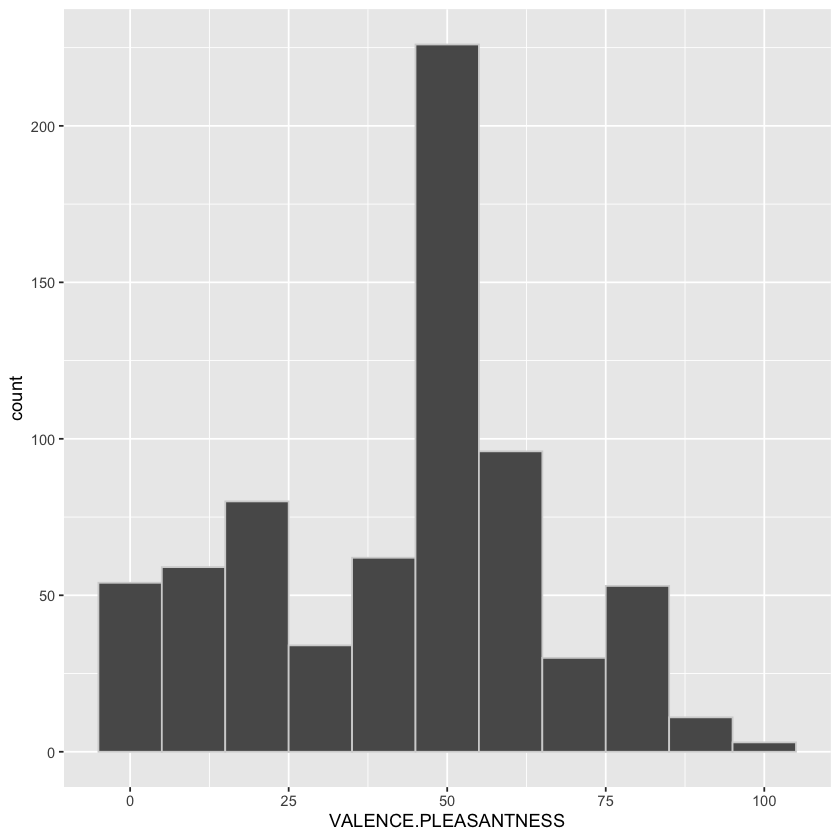

In [4]:
library(ggplot2)
library(magrittr)


train.data %>% ggplot(aes(VALENCE.PLEASANTNESS)) + geom_histogram(binwidth = 10, color = "lightgrey")
ggsave("../Pictures/Response_shape.png")

**Output variable (dependent variable): VALENCE.PLEASANTNESS**
- min. value (in the training set) = 0
- max. value (in the training set) = 98

**Input variables (predictors):**
- 4870 different predictors
- Intensity is a categorical variable with the levels low and high

**SWEETORSOUR:**
- output variable for the second task
- not included in the test set
- not usable for the regression task

## Missing Values 

We will make sure to remove all missing values if there are any

In [11]:
train.data = na.omit(train.data)

## Variance

In [12]:
#convert the variable intensity into 2=low and 1=high (so that we can apply variance and correlation)
numeric.intensity <- as.numeric(train.data$Intensity)


In [13]:
#searching for input variables with zero variance (without the varible Intensity)
y <- train.data$VALENCE.PLEASANTNESS
x <- train.data[, -c(2,3)]
x$Intensity <- numeric.intensity
n.before <- dim(x)[2] #numbers of predictors before the reduction
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]
n.after <- dim(x)[2] #numbers of predictors after the reduction

cat("Thereby we could reduce the number of predictors from" , n.before , " to " , n.after)

Thereby we could reduce the number of predictors from 4870  to  3028

## Visualization by PCA and tSNE

In [17]:
library(dplyr)
library("ggplot2")

Saving 7 x 7 in image


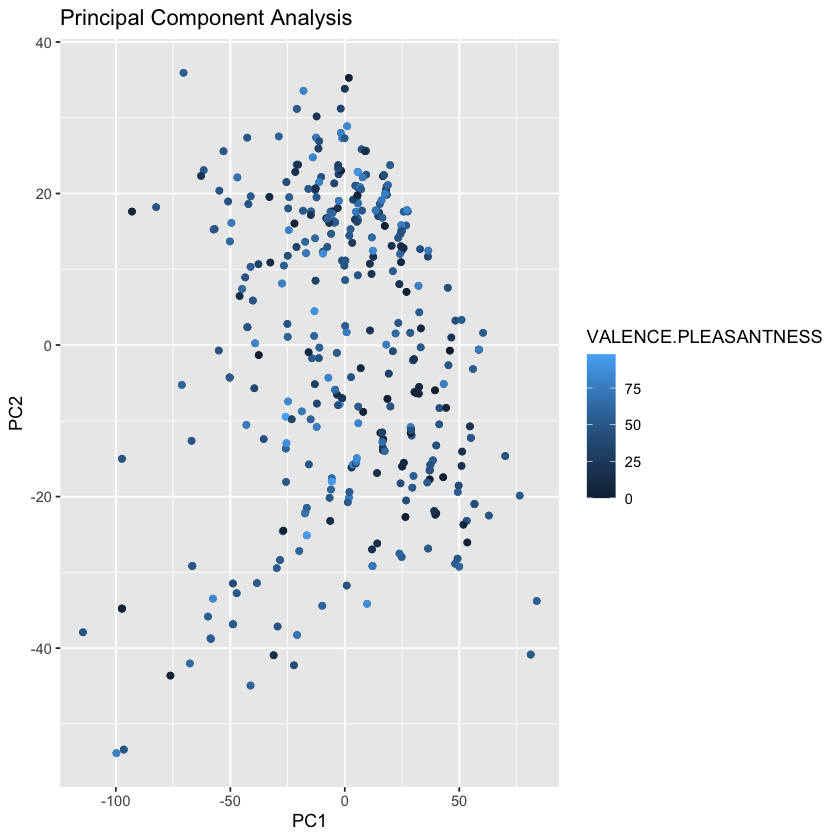

In [28]:
#PCA
pca <- prcomp(x, scale = T)
plot.data <- data.frame("PC1" = pca$x[,1], "PC2" = pca$x[,2], "VALENCE.PLEASANTNESS" = y)
plot.data %>% ggplot(aes(x = PC1, y = PC2, colour = VALENCE.PLEASANTNESS)) + geom_point() + ggtitle("Principal Component Analysis")
ggsave("../Pictures/PCA.png")

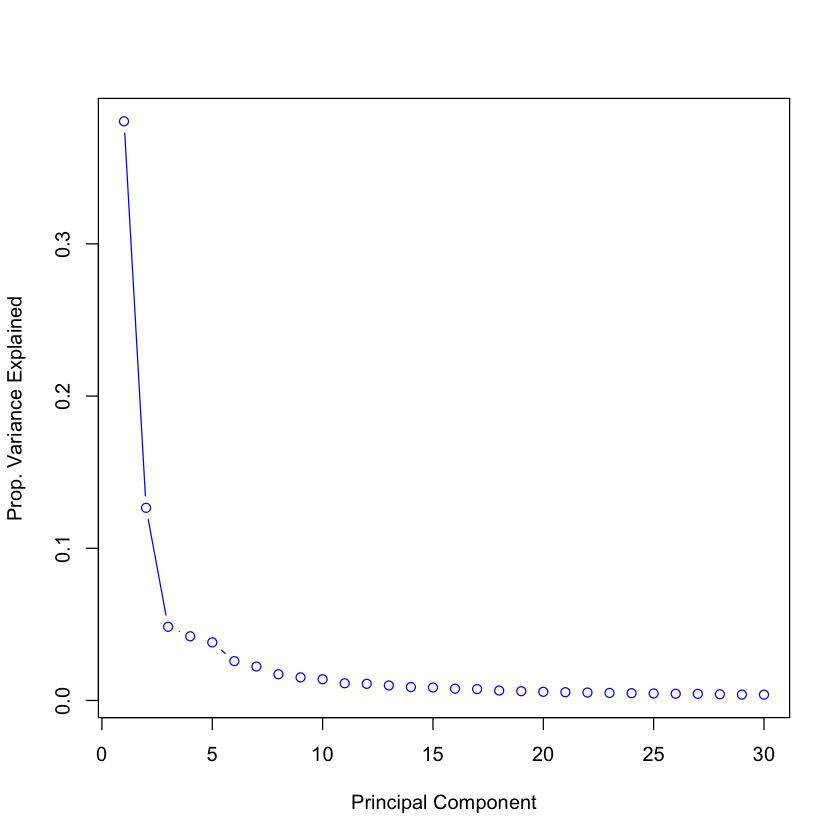

In [31]:
pca.var <- pca$sdev^2
pca.vare <- pca.var / sum(pca.var)
plot(pca.vare[1:30], xlab = "Principal Component", ylab = "Prop. Variance Explained", col = "blue", type = "b")

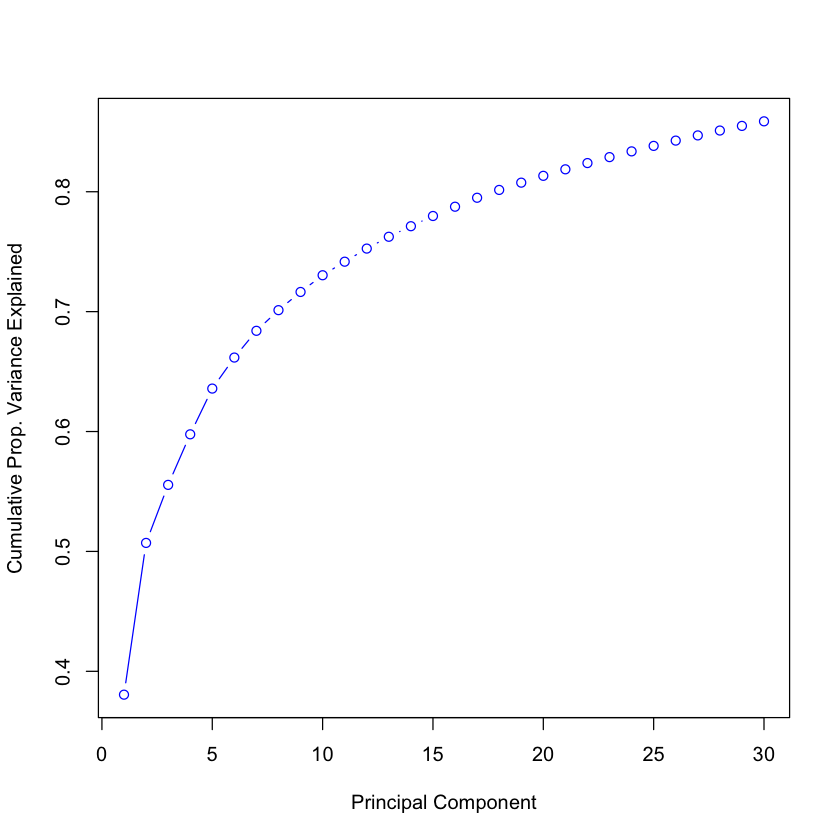

In [32]:

plot(cumsum(pca.vare[1:30]), xlab = "Principal Component", ylab = "Cumulative Prop. Variance Explained", col = "blue", type = "b")


Saving 7 x 7 in image


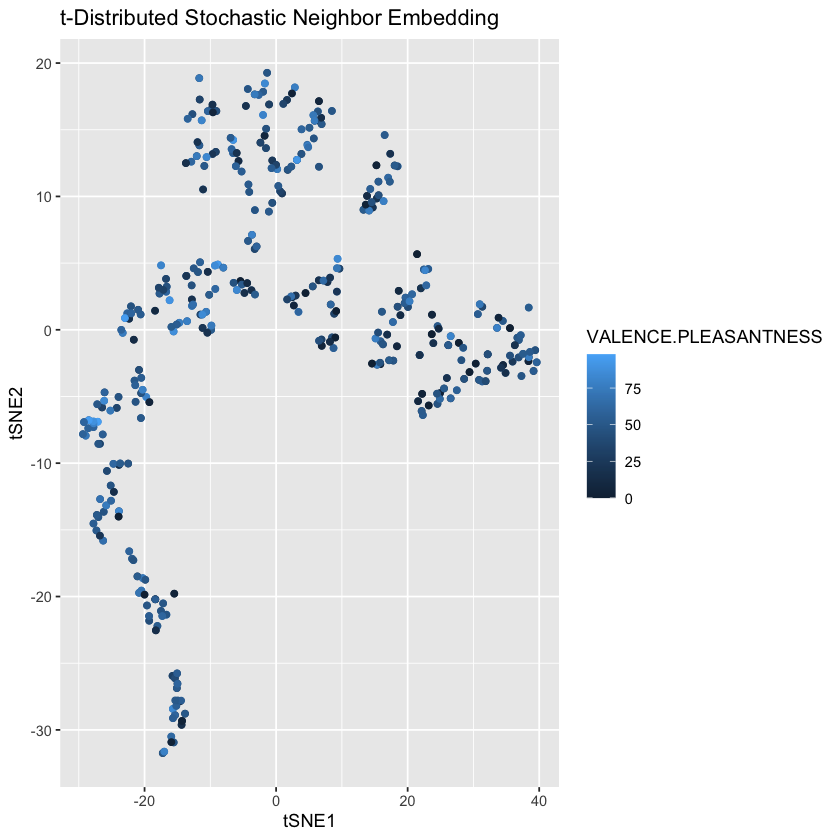

In [19]:
#tSNE
library(Rtsne)
tsne <- Rtsne(x, check_duplicates = FALSE)
plot.data <- data.frame("tSNE1" = tsne$Y[,1], "tSNE2" = tsne$Y[,2], "VALENCE.PLEASANTNESS" = y)
plot.data %>% ggplot(aes(x = tSNE1, y = tSNE2, colour = VALENCE.PLEASANTNESS)) + geom_point() + ggtitle("t-Distributed Stochastic Neighbor Embedding")
ggsave("../Pictures/tSNE.png")



We can not see clusters in PCA nor in tSNE, so that these analyses do not help us.

## Full linear Regression

In [64]:
#split the training data in a training set and a validation set
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)
train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

train <- x[idx.train,]
train$VALENCE.PLEASANTNESS <- y[idx.train]
validation <- x[-idx.train,]
validation$VALENCE.PLEASANTNESS <- y[-idx.train]

#full linear regression
full.linear.fit <- lm(VALENCE.PLEASANTNESS ~ ., train)

In [65]:
full.prediction.validation <- predict(full.linear.fit, validation)
MSE.validation <- mean((full.prediction.validation - validation$VALENCE.PLEASANTNESS)^2)

full.prediction.train <- predict(full.linear.fit, train)
MSE.train <- mean((full.prediction.train - train$VALENCE.PLEASANTNESS)^2)

cat("We obtained a validation MSE = ", MSE.validation, " and a training MSE = ", MSE.train)

Warning message in predict.lm(full.linear.fit, validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, train):
“prediction from a rank-deficient fit may be misleading”

We obtained a validation MSE =  19931235026  and a training MSE =  138.1428

We can see that the full linear model overfits the data highly. Indeed, we have a 10^11 value for the validation MSE. Therefore we have a much more higher validation MSE than training MSE.

We can see now if the validation MSE after multiple linear regression is reduced when counting for correlation between the predictors

## Correlation

First, we will look for perfectly correlated data in the dataset 

In [42]:
library(corrplot)
library(caret)
library(corrplot)
library(plyr)

#searching for variables with correlation = 1
corrData = scale(x, center=TRUE, scale = TRUE)  # normalize the data frame. This will also convert to a matrix. 
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)

highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 1)  # removes all indices of features which have a correltion of 0.99 or above
length(highlyCorrelated)

corrplot 0.84 loaded
Loading required package: lattice
Loading required package: ggplot2


[1] 0

There are zero variables which have a correlation index of 1. Hence no variables are completly correlated to each other. We can try to reduce the predictors with 0.95 correlation (or higher) and see if redoing a regression with Multiple Linear Regression gives us a smaller validation MSE.

In [43]:
#searching for variables with correlation = 0.95
corrData = scale(x, center=TRUE, scale = TRUE)  # normalize the data frame. This will also convert to a matrix. 
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.95)  # removes all indices of features which have a correlation of 0.95 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]  #Data frame with only uncorrelated data
dim(corr.x)

[1]  708 1195

It leads to a reduction of dimension from 3026 to 1195 predictors.
Now, let's split the training data into a training and a validation set and re perform linear regression on this new data set.

In [75]:
len <- length(corr.x[,1])
idx.train <- sample(1:len, 2*len/3)

corr.train <- corr.x[idx.train,]
corr.train$VALENCE.PLEASANTNESS <- y[idx.train]
corr.validation <- corr.x[-idx.train,]
corr.validation$VALENCE.PLEASANTNESS <- y[-idx.train]

full.linear.fit <- lm(VALENCE.PLEASANTNESS ~ ., corr.train)


In [76]:
full.prediction.validation <- predict(full.linear.fit, corr.validation)
MSE.validation <- mean((full.prediction.validation - corr.validation$VALENCE.PLEASANTNESS)^2)

full.prediction.train <- predict(full.linear.fit, corr.train)
MSE.train <- mean((full.prediction.train - corr.train$VALENCE.PLEASANTNESS)^2)

cat("We obtained a validation MSE = ", MSE.validation, " and a training MSE = ", MSE.train)

Warning message in predict.lm(full.linear.fit, corr.validation):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(full.linear.fit, corr.train):
“prediction from a rank-deficient fit may be misleading”

We obtained a validation MSE =  10157943735  and a training MSE =  145.8236

We can observe that the validation MSE is not reduced significantly after having removed the correlated variables

We will move on to Linear Methods that penalizes the flexibility of the model. In fact, as we have much more predictors than variables, our model is too flexible and it results in overfitting the training set. Some well known methods such as Lasso Regularization, Forward Selection with cross-validation will be used to try to reduce the validation MSE by penalizing and reducing some predictors to 0.

## Linear Regression with Lasso Regularization and K-Fold Cross Validation

First, Lasso regularization method is used. This process aims at restricting the features while modelling to minimize the risk of overfitting. We will also test this method with both correlated and uncorrelated variables to see if we have a difference in the validation MSE.

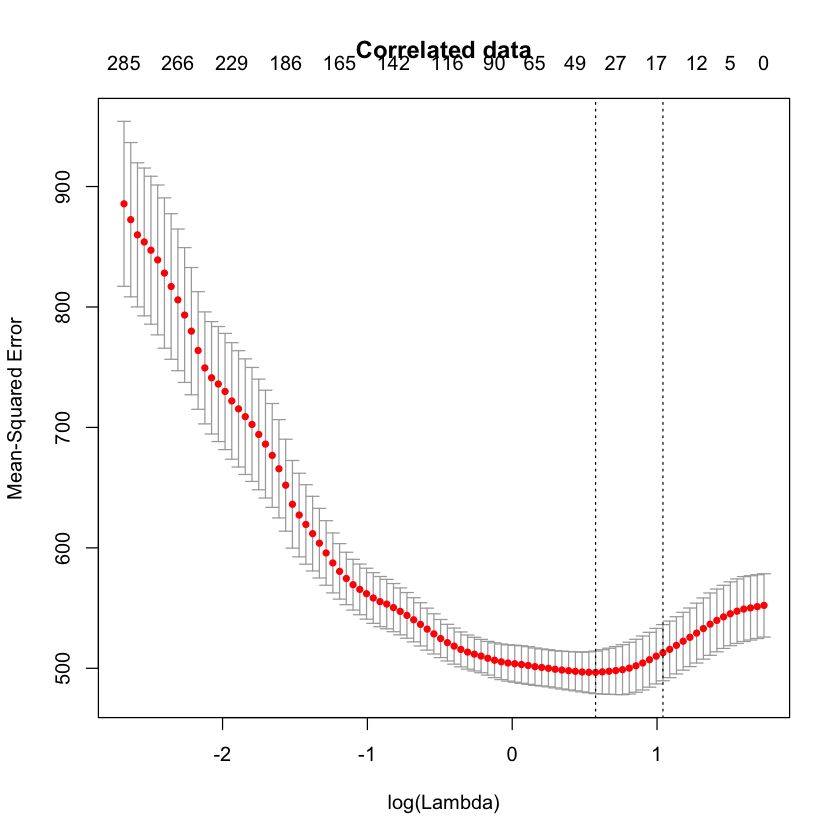

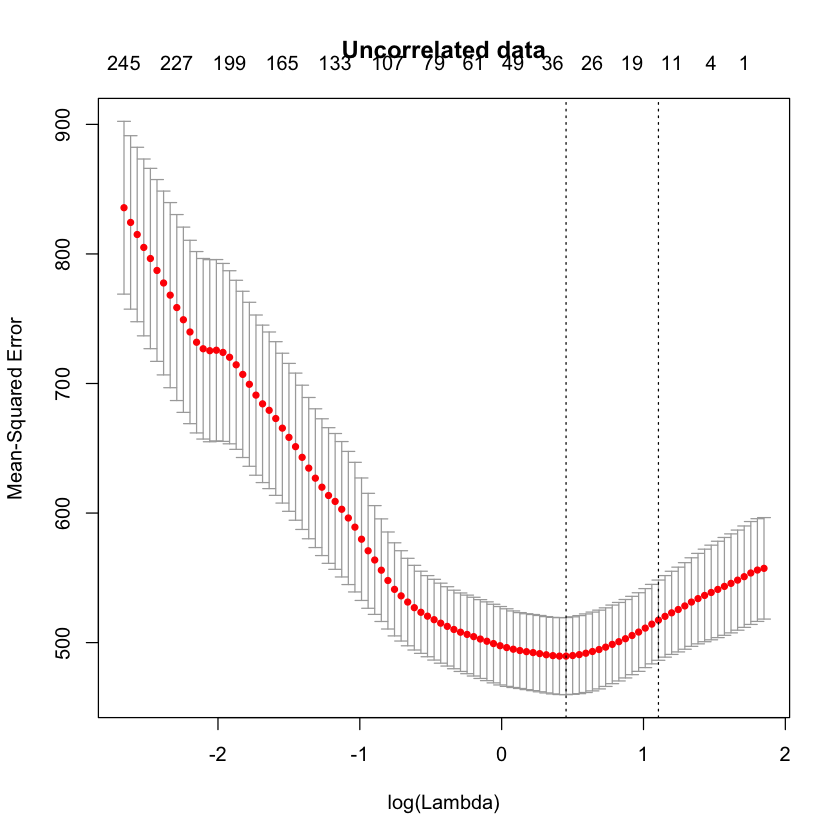

In [105]:
library(glmnet)



#split the training data in a training set and a validation set for correlated data
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)
train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

#split the training data in a training set and a validation set for uncorrelated data
len.corr <- length(corr.x[,1])
idx.train <- sample(1:len.corr, 2*len.corr/3)
corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])


#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
plot(cv.lasso, main = "Correlated data")

corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)
plot(corr.cv.lasso, main = "Uncorrelated data")

One can see that it is clearly better to not include all variables for a linear regression (as expected).  

In [107]:
#best prediction for correlated
best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = (val.x))
#best prediction for uncorrelated
corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)
corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = as.matrix(corr.val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)
mean((corr.pred - corr.val.y)^2)

[1] 470.0712

[1] 491.7823

The validation MSE has decreased significantly with Lasso regression with 5-fold cross validation, but it is still the same approximate value for both the correlated and uncorrelated data.

Since the MSE does not diminish significantly when we remove correlated variables, we conserve all 3028 predictors for the further analyse.

Additionally, we can see that the MSE is around 450-520. 

In the same way, let's perform Ridge Regularization to see if it improves our model.

In [108]:
#RIDGE REGRESSION : Alpha = 0
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])


#Ridge Regression models
lasso.mod <- glmnet(train.x,train.y, alpha = 0, lambda = 10^seq(1, -2, length = 150))
corr.lasso.mod <- glmnet(corr.train.x,corr.train.y, alpha = 0, lambda = 10^seq(1, -2, length = 150))


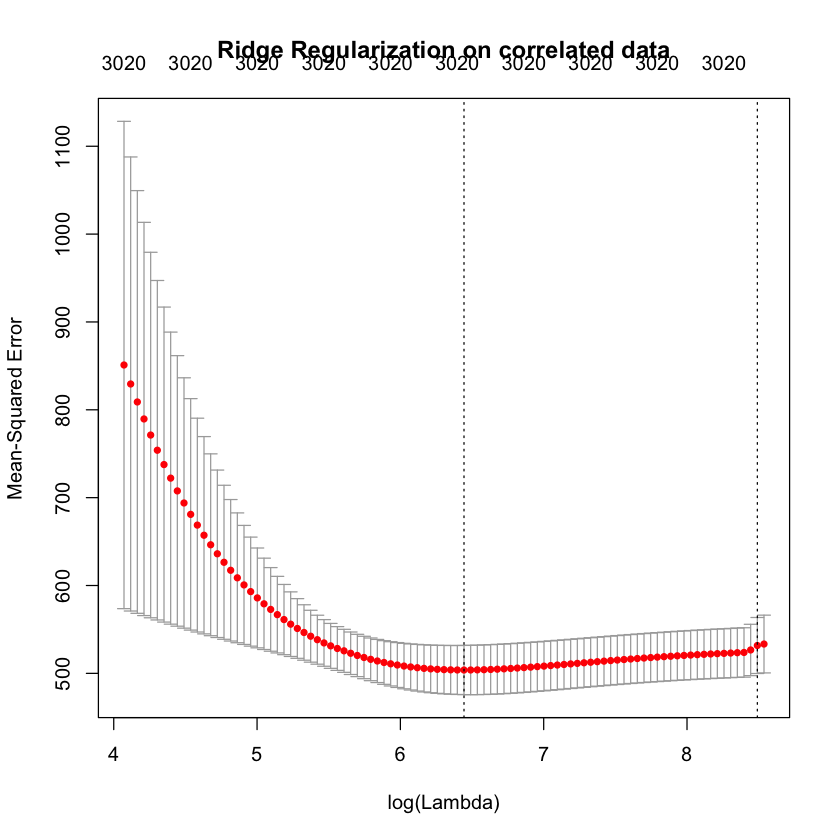

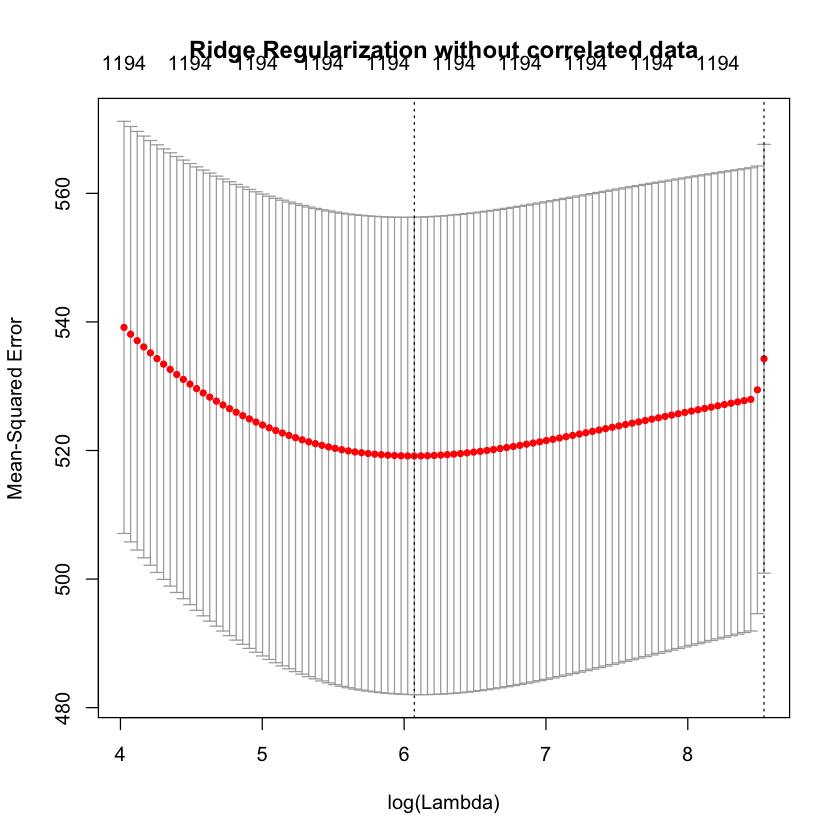

In [109]:
#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 0, nfold = 5)
plot(cv.lasso, main = "Ridge Regularization on correlated data")

corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 0, nfold = 5)
plot(corr.cv.lasso, main = "Ridge Regularization without correlated data")

In [114]:
#best prediction for both correlated and uncorrelated variables 

best.lasso <- glmnet(train.x, train.y, alpha = 0, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = val.x)

corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 0, lambda = corr.cv.lasso$lambda.min)
corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = as.matrix(corr.val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)
mean((corr.pred - corr.val.y)^2)

[1] 487.4166

[1] 487.5737

Ridge Regression does not result in a significant change in the MSE and does not change with correlated or uncorrelated variables. 

Now we will try stepwise feature selection. Stepwise regression is a method of fitting regression models in which the choice of predictive variables is carried out by an automatic procedure. 
We will do the Forward Selection technique 

## Forward Selection with Cross-Validation

In [115]:
library(tidymodels)
library(leaps)

#functions 
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}


evaluate <- function(fold, fit, formula = VALENCE.PLEASANTNESS ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, id, formula))^2))
}

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 30)
    evaluate(fold, fit)
}

#data
full.data <- x
full.data$VALENCE.PLEASANTNESS <- y
validation.data <- vfold_cv(full.data, v = 5)           
           
cv.errors <- sapply(validation.data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──
✔ broom     0.7.2      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.8 
✔ dplyr     1.0.2      ✔ tibble    3.0.4 
✔ infer     0.5.3      ✔ tidyr     1.1.2 
✔ modeldata 0.1.0      ✔ tune      0.1.2 
✔ parsnip   0.1.4      ✔ workflows 0.2.1 
✔ purrr     0.3.4      ✔ yardstick 0.0.7 
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::accumulate()      masks foreach::accumulate()
✖ dplyr::arrange()         masks plyr::arrange()
✖ purrr::compact()         masks plyr::compact()
✖ dplyr::count()           masks plyr::count()
✖ purrr::discard()         masks scales::discard()
✖ tidyr::expand()          masks Matrix::expand()
✖ dplyr::failwith()        masks plyr::failwith()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::id()              masks plyr::id()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::lift()            masks caret::lift()
✖ dplyr

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2711  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2713  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2705  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2714  linear dependencies found”

Reordering variables and trying again:


We obtained a validation MSE =  489.8704  for  16  predictors

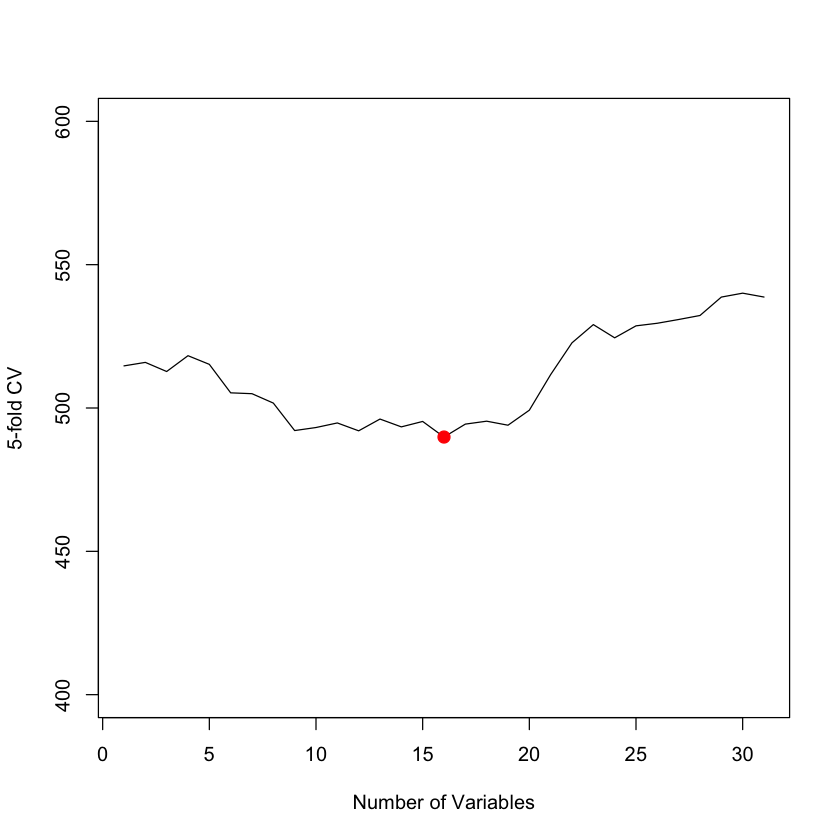

In [117]:
#plot the obtained data
plot(mean.cv.errors, type = "l", ylim = c(400, 600), xlab = "Number of Variables", ylab = "5-fold CV")
cv.min <- which.min(mean.cv.errors)
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(full.data$VALENCE.PLEASANTNESS), 0, lty = "dashed")

cat("We obtained a validation MSE = ",mean.cv.errors[cv.min], " for ", which.min(mean.cv.errors), " predictors")

We can see that the best predictions are obtained with a small number of variables (16 variables). 

## Neural Network

In this section, we will try to predict the response variable with a non linear machine learning method called neural network. We have 3024 input independent variables and 1 reponse dependent variable. We will use keras library.library(tensorflow)

In [24]:
library(keras)
library(dplyr) 
use_condaenv('r-tensorflow')


Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [161]:

len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
test.x <- as.matrix(x[-idx.train,])
test.y <- as.matrix(y[-idx.train])

train.x.prep <- scale(train.x, center = T, scale = T)
train.y.prep <- scale(train.y, center = T, scale = T)

test.x.prep = scale(test.x, center = T, scale = T)
test.y.prep = scale(test.y, center = T, scale = T)

In [1]:
nn <- keras_model_sequential()
nn <- nn %>%
      layer_dense(units = 50, activation = 'relu', input_shape = c(dim(train.x)[2])) %>%
      layer_dropout(rate=0.4)%>%
      layer_dense(units = 50, activation = 'relu') %>%
      layer_dense(units = 1, activation = 'linear')

ERROR: Error in keras_model_sequential(): impossible de trouver la fonction "keras_model_sequential"


In [134]:
nn %>% compile(
    loss = 'mean_squared_error',
    optimizer = "adam", 
    metrics = list("mean_absolute_error"))


In [135]:
# Train the neural network
history <- nn %>% fit(
    train.x.prep,
    train.y.prep,
    verbose = 0,
    validation_split = 0,                                       
    epochs = 500)

summary(history)


        Length Class  Mode
params  7      -none- list
metrics 2      -none- list

In [ ]:
nn.pred <- predict(nn, test.x.prep)
nn.pred
#mean((y.unscale(nn.pred, train.y.prep) - test.y)^2)

In [31]:
scores = nn %>% evaluate(train.x, train.y, verbose = 0)
scores

$loss
[1] 0.3635792

$mean_absolute_error
[1] 0.4582012

In [51]:
pred = predict(nn, test.x)
mean((pred - test.y)^2)

[1] 2.5247

## Boosting 

In this section, we will try the powerful boosting method, which does need any pre-processing of the data and does not depend on the initial conditions. 

In [1]:
install.packages("xgboost")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [ ]:
library(xgboost)
set.seed(1)
#pows <- seq(-3.5, -0.2, by = 0.1)
#lambdas <- 10^pows

#Split data into a training and a test set 
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.y <- y[idx.train]
train.x <- as.matrix(x[idx.train,])
test.y <- y[-idx.train]
test.x <- as.matrix(x[-idx.train,])


boost.pleasantness <- xgboost(train.x,
                           label=train.y,
                            eta=0.005,
                            objective="reg:squarederror",
                            max.depth=6,
                            nrounds=2000,
                            verbose = 0)



In [22]:
pred.train <- predict(boost.pleasantness, train.x)
pred.test <- predict(boost.pleasantness, test.x)
  train.err <- mean((pred.train - train.y)^2)
train.err
  test.err <- mean((pred.test - test.y)^2)
test.err


[1] 22.02981

[1] 595.3475

In [51]:
library(xgboost)
set.seed(1)
#pows <- seq(-3.5, -0.2, by = 0.1)
#lambdas <- 10^pows

#Split data into a training and a test set 
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.y <- y[idx.train]
train.x <- as.matrix(x[idx.train,])
test.y <- y[-idx.train]
test.x <- as.matrix(x[-idx.train,])

#Changed eta + max.dept + nrounds

boost.pleasantness <- xgboost(train.x,
                           label=train.y,
                            eta=0.05,
                            objective="reg:squarederror",
                            max.depth=3,
                            nrounds=100,
                            verbose = 0)



In [53]:
pred.train <- predict(boost.pleasantness, train.x)
pred.test <- predict(boost.pleasantness, test.x)
  train.err <- mean((pred.train - train.y)^2)
  test.err <- mean((pred.test - test.y)^2)

train.err
test.err

[1] 200.1977

[1] 519.5424

In [ ]:
#BOOSTING ON UNCORRELATED VARIABLES

#split the training data in a training set and a validation set for uncorrelated data
len.corr <- length(corr.x[,1])
idx.train <- sample(1:len.corr, 2*len.corr/3)
corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- y[idx.train]
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- y[-idx.train]

boost.pleasantness <- xgboost(corr.train.x,
                           label=corr.train.y,
                            eta=0.05,
                            objective="reg:squarederror",
                            max.depth=3,
                            nrounds=100,
                            verbose = 1)



In [48]:
pred.train <- predict(boost.pleasantness, corr.train.x)
pred.test <- predict(boost.pleasantness, corr.val.x)
  train.err <- mean((pred.train - corr.train.y)^2)
  test.err <- mean((pred.test - corr.val.y)^2)

train.err
test.err

[1] 207.6324

[1] 510.0064

## General Additive Model 

GAMs allow us to fit a non-linear function to each independent variable, so that we can automatically model non-linear relationships that standard linear regression will miss.

In [162]:
 
 library(mgcv)  

In [167]:
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

data.train.x <- x[idx.train,]
data.train.y <- y[idx.train]


validation <- x[-idx.train,]
validation$VALENCE.PLEASANTNESS <- y[-idx.train]

#GAM regression
gam.fit <- gam(data.train.y ~.-data.train.y, data.frame(data.train.x,data.train.y), family = gaussian)
#gam.prediction = predict(gam.fit, data.frame(validation))



ERROR: Error in terms.formula(gf, specials = c("s", "te", "ti", "t2", extra.special)): '.' dans la formule et pas d'argument 'data'
